In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# set sns style to sci
sns.set_style("whitegrid")

sys.path.append("../")
from UpStraight_Visualize import plot_day
from UpStraight_Data import get_appData, get_health_data, training_columns, get_training_data

In [9]:
appData = get_appData(save=True)

In [51]:
health = get_health_data(save=True)

/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../UpStraight_Data.py:44: DtypeWarning: Columns (16,24,25,27,39,40,47,56) have mixed types. Specify dtype option on import or set low_memory=False.
  health.to_csv("../data/health.csv",index=False)
/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../apple_watch_data_package/Apple_Data.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["start"] = pd.to_datetime(data.startDate)
/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../apple_watch_data_package/Apple_Data.py:17: SettingWithCopyWarning: 
A value is t

In [37]:
# get min and max date for each source
appData.groupby("source").agg({"day_date":["min","max","count"]})

day_date                  
               min         max count
source                              
as      2023-02-12  2023-03-13    81
cr      2023-02-10  2023-03-01   139
dotz    2023-02-12  2023-02-25    90
far     2023-02-12  2023-02-22    41
lass    2023-02-10  2023-02-23   116

In [38]:
# get min and max daydate from health_as
health.groupby("source").agg({"day_date":["min","max","count"]})

day_date                   
               min         max  count
source                               
as      2023-02-12  2023-03-13   8502
cr      2023-02-10  2023-03-02  31492
dotz    2023-02-12  2023-03-01  78609
far     2023-02-12  2023-02-26  26019
lass    2023-02-10  2023-03-02  83752

### Cross sectional plots

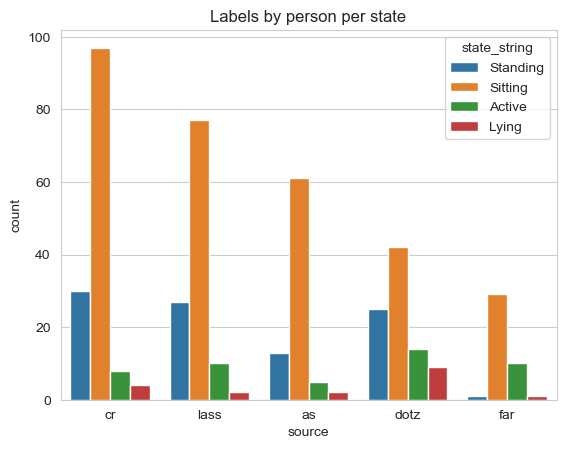

In [21]:
# plotting relative proportions of each state
sns.countplot(appData,x="source",hue="state_string")
plt.title("Labels by person per state")
plt.show()

In [10]:
appData.source.value_counts(normalize=True)

cr      0.297645
lass    0.248394
dotz    0.192719
as      0.173448
far     0.087794
Name: source, dtype: float64

In [11]:
appData.shape

(467, 10)

In [ ]:
# summary table of counts by source and state
appData.groupby(["source","state_string"]).size().unstack().fillna(0).astype(int)

state_string,Active,Lying,Sitting,Standing
source,,,,
as,5,2,61,13
cr,8,4,97,30
dotz,14,9,42,25
far,10,1,29,1
lass,10,2,77,27


### Model

One can either train a model for each user, or a combined model for all at once.
The likely optimal approach is a combination of both: To use all of the available data, yet adjust the weights on own data points.

**Outline**

1. Train a combined model using data from all users
2. Train a separate model using data only from the user
3. Train a mixed model using data from all users but weighting own data higher

**Evaluation**

- We cross validate an accuracy trained model and assess both on accuracy and an economic score based on weighted entries of the confusion matrix. In particular, we would like to be conservative, and prefer false negatives over false positives.

**Architecture**

- RandomForest

In [3]:
X_train = pd.read_csv("../data/X_train.csv")
X_train.shape

(467, 44)

#### Feature Analysis

In [4]:
X_train.isna().sum()

date                               0
state                              0
posture                            0
source                             0
day_date                           0
day                                0
time                               0
hour                               0
state_string                       0
posture_string                     0
HeartRate_15_mean                 21
HeartRate_15_max                  21
HeartRate_15_min                  21
HeartRate_15_std                  36
HeartRate_15_range                21
ActiveEnergyBurned_15_mean        12
ActiveEnergyBurned_15_max         12
ActiveEnergyBurned_15_min         12
ActiveEnergyBurned_15_std         17
ActiveEnergyBurned_15_range       12
AppleStandTime_15_mean            26
AppleStandTime_15_max             26
AppleStandTime_15_min             26
AppleStandTime_15_std             52
AppleStandTime_15_range           26
HeartRate_15_ar1_coef              0
ActiveEnergyBurned_15_ar1_coef     0
H

In [5]:
# drop apple stand time variation: it has the most missing values and is likely not very informative
X_train.drop(["AppleStandTime_30_std","AppleStandTime_15_std"],axis=1,inplace=True)

In [6]:
# drop rows with missing values
X_prep = X_train.dropna()

In [7]:
X_prep.shape

(415, 42)

In [8]:
# map all non-slouching postures to 0 for the slouching prediction
X_prep["posture"] = X_prep["posture"].map({-1:0,1:1,0:0})
X_prep.posture.value_counts()

/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_66452/297281604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_prep["posture"] = X_prep["posture"].map({-1:0,1:1,0:0})


1    239
0    176
Name: posture, dtype: int64

#### 1) Completely ignoring the user structure

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from UpStraight_Train import ColumnSelector, training_columns


In [43]:
y = X_prep["posture"]
X = X_prep.drop("posture",axis=1)
# define parameter grid
param_grid = {"clf__max_depth": [3, 5,7,9,12], "clf__n_estimators": [10, 30, 50, 100, 200]}
# define classifier
clf = RandomForestClassifier(random_state=42)
# define pipeline
pipe = Pipeline([("col_selector", ColumnSelector(columns=training_columns)),("clf",clf)])
# define grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=4, n_jobs=-1, verbose=1)
results = grid_search.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


In [44]:
pd.DataFrame(results.cv_results_).sort_values("rank_test_score").head(8)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,0.031635,0.000971,0.002410,0.000064,3,50,"{'clf__max_depth': 3, 'clf__n_estimators': 50}",0.721154,0.826923,0.750000,0.669903,0.741995,0.056808,1
1,0.019017,0.000096,0.001841,0.000034,3,30,"{'clf__max_depth': 3, 'clf__n_estimators': 30}",0.721154,0.836538,0.750000,0.660194,0.741972,0.063499,2
4,0.137984,0.016811,0.006046,0.000015,3,200,"{'clf__max_depth': 3, 'clf__n_estimators': 200}",0.730769,0.826923,0.740385,0.660194,0.739568,0.059180,3
3,0.079553,0.014278,0.003594,0.000022,3,100,"{'clf__max_depth': 3, 'clf__n_estimators': 100}",0.730769,0.826923,0.740385,0.650485,0.737141,0.062492,4
9,0.169020,0.011281,0.007889,0.002648,5,200,"{'clf__max_depth': 5, 'clf__n_estimators': 200}",0.701923,0.778846,0.778846,0.669903,0.732380,0.047826,5
6,0.027027,0.009758,0.002092,0.000341,5,30,"{'clf__max_depth': 5, 'clf__n_estimators': 30}",0.701923,0.798077,0.730769,0.689320,0.730022,0.042066,6
0,0.007448,0.000206,0.001191,0.000083,3,10,"{'clf__max_depth': 3, 'clf__n_estimators': 10}",0.721154,0.836538,0.730769,0.631068,0.729882,0.072830,7
7,0.046627,0.011042,0.002431,0.000083,5,50,"{'clf__max_depth': 5, 'clf__n_estimators': 50}",0.701923,0.788462,0.730769,0.689320,0.727619,0.038206,8


[]

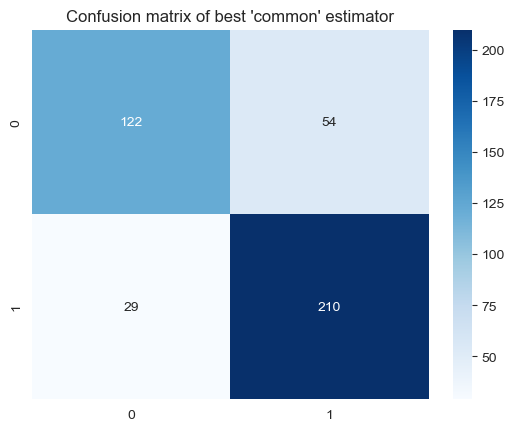

In [45]:
# plot confusion matrix of best estimator:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

common_est = results.best_estimator_
y_pred = common_est.predict(X)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt="d",cmap="Blues")
plt.title("Confusion matrix of best 'common' estimator")
plt.plot()

In [46]:
# plot confusion matrix of best estimator:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.69      0.75       176
           1       0.80      0.88      0.83       239

    accuracy                           0.80       415
   macro avg       0.80      0.79      0.79       415
weighted avg       0.80      0.80      0.80       415



#### 2) Completely ignoring other user data, only using own-data

In [140]:
from UpStraight_Train import get_user_data

2.1 For CR

In [141]:
X,y = get_user_data(X_prep,source="cr")

# define parameter grid
param_grid = {"clf__max_depth": [3, 5,7,9,12], "clf__n_estimators": [10, 30, 50, 100, 200]}
# define classifier
clf = RandomForestClassifier(random_state=42)
# define pipeline
pipe = Pipeline([("col_selector", ColumnSelector(columns=training_columns)),("clf",clf)])
# define grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=4, n_jobs=-1, verbose=1)
results = grid_search.fit(X, y)

pd.DataFrame(results.cv_results_).sort_values("rank_test_score").head(8)


Fitting 4 folds for each of 25 candidates, totalling 100 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
5,0.008227,0.003333,0.001212,0.000070,5,10,"{'clf__max_depth': 5, 'clf__n_estimators': 10}",0.733333,0.666667,0.800000,0.633333,0.708333,0.064010,1
7,0.041675,0.019606,0.004935,0.004652,5,50,"{'clf__max_depth': 5, 'clf__n_estimators': 50}",0.733333,0.633333,0.733333,0.566667,0.666667,0.070711,2
19,0.110086,0.007582,0.005800,0.000232,9,200,"{'clf__max_depth': 9, 'clf__n_estimators': 200}",0.766667,0.600000,0.766667,0.500000,0.658333,0.113957,3
0,0.006468,0.000138,0.001206,0.000080,3,10,"{'clf__max_depth': 3, 'clf__n_estimators': 10}",0.766667,0.633333,0.700000,0.533333,0.658333,0.086201,4
14,0.123074,0.012883,0.005803,0.000112,7,200,"{'clf__max_depth': 7, 'clf__n_estimators': 200}",0.700000,0.633333,0.766667,0.500000,0.650000,0.098601,5
13,0.064205,0.008725,0.006241,0.004860,7,100,"{'clf__max_depth': 7, 'clf__n_estimators': 100}",0.733333,0.633333,0.733333,0.500000,0.650000,0.095743,5
24,0.111670,0.005887,0.005935,0.000297,12,200,"{'clf__max_depth': 12, 'clf__n_estimators': 200}",0.733333,0.600000,0.766667,0.500000,0.650000,0.106719,5
8,0.074802,0.007956,0.003596,0.000246,5,100,"{'clf__max_depth': 5, 'clf__n_estimators': 100}",0.733333,0.600000,0.733333,0.533333,0.650000,0.086603,8


[]

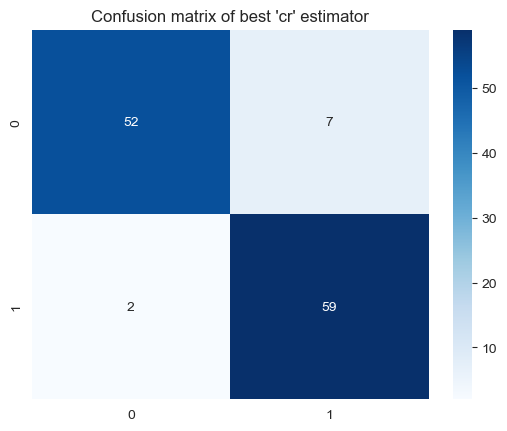

In [142]:
# confusion matrix again:

best_cr = results.best_estimator_
y_pred = best_cr.predict(X)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt="d",cmap="Blues")
plt.title("Confusion matrix of best 'cr' estimator")
plt.plot()

In [49]:
# classification report again:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92        59
           1       0.89      0.97      0.93        61

    accuracy                           0.93       120
   macro avg       0.93      0.92      0.92       120
weighted avg       0.93      0.93      0.92       120



In [50]:
# Doing the same for lass data:

X,y = get_user_data(X_prep,source="lass")
# define parameter grid
param_grid = {"clf__max_depth": [3, 5,7,9,12], "clf__n_estimators": [10, 30, 50, 100, 200]}
# define classifier
clf = RandomForestClassifier(random_state=42)
# define pipeline
pipe = Pipeline([("col_selector", ColumnSelector(columns=training_columns)),("clf",clf)])
# define grid search
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=4, n_jobs=-1, verbose=1)
results = grid_search.fit(X, y)

pd.DataFrame(results.cv_results_).sort_values("rank_test_score").head(8)


Fitting 4 folds for each of 25 candidates, totalling 100 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
6,0.019537,0.004616,0.001776,0.000043,5,30,"{'clf__max_depth': 5, 'clf__n_estimators': 30}",0.928571,0.888889,0.888889,0.740741,0.861772,0.071731,1
11,0.018690,0.002475,0.001751,0.000084,7,30,"{'clf__max_depth': 7, 'clf__n_estimators': 30}",0.892857,0.888889,0.888889,0.740741,0.852844,0.064743,2
21,0.019050,0.003411,0.001811,0.000040,12,30,"{'clf__max_depth': 12, 'clf__n_estimators': 30}",0.892857,0.888889,0.888889,0.740741,0.852844,0.064743,2
16,0.021010,0.005251,0.001728,0.000106,9,30,"{'clf__max_depth': 9, 'clf__n_estimators': 30}",0.892857,0.888889,0.888889,0.740741,0.852844,0.064743,2
3,0.058464,0.002310,0.007439,0.002857,3,100,"{'clf__max_depth': 3, 'clf__n_estimators': 100}",0.928571,0.814815,0.888889,0.777778,0.852513,0.059402,5
9,0.193595,0.052098,0.005662,0.000036,5,200,"{'clf__max_depth': 5, 'clf__n_estimators': 200}",0.928571,0.851852,0.888889,0.740741,0.852513,0.070003,5
12,0.051157,0.033386,0.002242,0.000053,7,50,"{'clf__max_depth': 7, 'clf__n_estimators': 50}",0.928571,0.814815,0.888889,0.740741,0.843254,0.071902,7
14,0.138066,0.031661,0.007325,0.001689,7,200,"{'clf__max_depth': 7, 'clf__n_estimators': 200}",0.928571,0.814815,0.888889,0.740741,0.843254,0.071902,7


[]

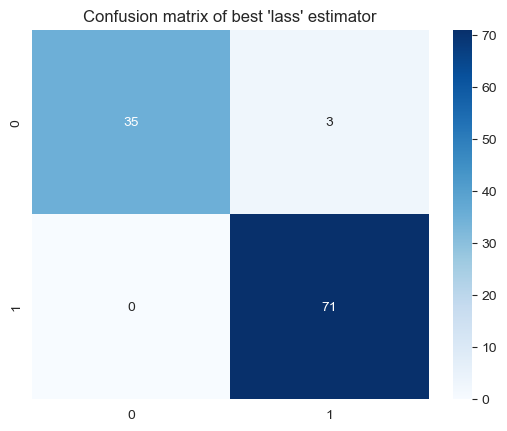

In [52]:
best_lass = results.best_estimator_
sns.heatmap(confusion_matrix(y,best_lass.predict(X)),annot=True,fmt="d",cmap="Blues")
plt.title("Confusion matrix of best 'lass' estimator")
plt.plot()

In [53]:
# classificaiton report again:
print(classification_report(y,best_lass.predict(X)))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        38
           1       0.96      1.00      0.98        71

    accuracy                           0.97       109
   macro avg       0.98      0.96      0.97       109
weighted avg       0.97      0.97      0.97       109



This looks very promising! The question is if we can do better by using the other user data as well. This could

- add information, and make predictions more accurate, or 
- introduce nodes based on different data distributions, and reduce quality of the model. 

However, even in the latter case where accuracy metrics drops, it might reduce bias and generalize better...

#### 3) Using other user data

#### 3.1) [UPDATE: NOT CONTINUED.] Using other user data, but **just** as training data that is never used for prediction/evaluation

To do this, we split the source data into train and test. We then train on the train subset of source data and all non-source data, and predict on the test subset of source data.
In the cross-validation, we use the same approach, making use of a custom splitting function that shuffle splits only the source data.
Since most of the training data does not vary across splits, we expect less variance.

In [118]:
# get a split
y = X_prep["posture"]
X = X_prep.drop("posture",axis=1)
splits = get_n_splits(X,y, source="lass", n_splits=5, random_state=42,test_size=0.3)

In [119]:
some_split = next(splits)
print(len(some_split[0]), len(some_split[1]))
print(some_split[1])


382 33
[ 68  22  62  90   4  95  54  71  32  25  42   1  35  31  94  45  46  81
  92  84  15  57  77  61  78 107  34  55   8  87  20   9  10]


In [121]:
from UpStraight_Train import get_n_splits

#TODO: Fix thix index error. the splitter seems to behave correctly, unclear where this is coming from...
y = X_prep["posture"]
X = X_prep.drop("posture",axis=1)
# pass data into generator
custom_cv_splits = get_n_splits(X,y, source="lass",n_splits=4,test_size=0.3)
clf = RandomForestClassifier(random_state=42)
pipe = Pipeline([("col_selector",ColumnSelector(columns=training_columns)),("clf",clf)])
grid_search = GridSearchCV(pipe,param_grid=param_grid,cv=custom_cv_splits,n_jobs=-1,verbose=1)
results = grid_search.fit(X,y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


IndexError: indices are out-of-bounds

#### 3.2) Using other user data both for training and evaluation, but using weights

In [131]:
from UpStraight_Train import get_training_weights

In [153]:
def cv_train_user(X_prep, source, target_weight=0.7,test_size=0.15):
    y = X_prep["posture"]
    X = X_prep.drop("posture",axis=1)
    # map source to 1 if from source else 0
    X["source"] = X["source"].map(lambda x: 1 if x==source else 0)
    # Grid settings
    param_grid = {"clf__max_depth": [3,4,5,7,9],"clf__n_estimators": [10,20,30,40,50]}
    custom_cv = StratifiedShuffleSplit(n_splits=4,test_size=test_size,random_state=42)
    # use source as additional variable in making splits to ensure that source data points are in each split
    y_stratification = pd.concat([y,X["source"]],axis=1)
    splits = custom_cv.split(X,y_stratification)
    rf_grid = GridSearchCV(Pipeline([("col_selector",ColumnSelector(columns=training_columns)),("clf",RandomForestClassifier())]),param_grid=param_grid,cv=splits,verbose=1,n_jobs=-1)
    rf_results = rf_grid.fit(X,y,clf__sample_weight= get_training_weights(X,target=target_weight))
    return rf_results

In [154]:
r_cr = cv_train_user(X_prep,"cr",target_weight=0.7,test_size=0.1)
pd.DataFrame(r_cr.cv_results_).sort_values("mean_test_score",ascending=False).head()

Fitting 4 folds for each of 25 candidates, totalling 100 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
19,0.052020,0.007306,0.002373,0.000034,7,50,"{'clf__max_depth': 7, 'clf__n_estimators': 50}",0.809524,0.857143,0.833333,0.714286,0.803571,0.054229,1
9,0.038149,0.004022,0.002820,0.000943,4,50,"{'clf__max_depth': 4, 'clf__n_estimators': 50}",0.857143,0.809524,0.809524,0.714286,0.797619,0.051892,2
14,0.048248,0.007788,0.002320,0.000031,5,50,"{'clf__max_depth': 5, 'clf__n_estimators': 50}",0.833333,0.785714,0.785714,0.761905,0.791667,0.025946,3
21,0.019469,0.001384,0.001609,0.000040,9,20,"{'clf__max_depth': 9, 'clf__n_estimators': 20}",0.785714,0.809524,0.785714,0.761905,0.785714,0.016836,4
7,0.022625,0.002284,0.002591,0.001423,4,30,"{'clf__max_depth': 4, 'clf__n_estimators': 30}",0.809524,0.738095,0.809524,0.761905,0.779762,0.030929,5


In [155]:
best_cr_weighted = r_cr.best_estimator_

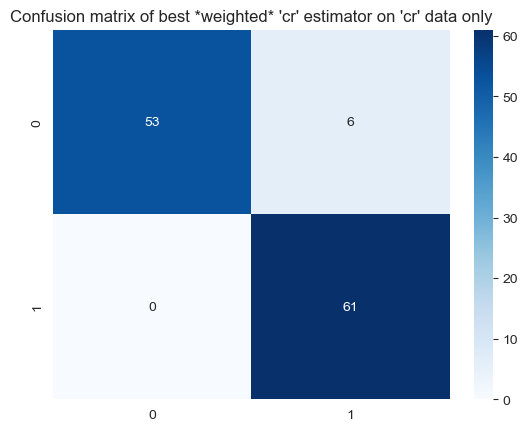

In [156]:
# confusion matrix of best estimator on cr data only:
X_cr,y_cr = get_user_data(X_prep,source="cr")
y_cr_pred = best_cr_weighted.predict(X_cr)
sns.heatmap(confusion_matrix(y_cr,y_source_pred),annot=True,fmt="d",cmap="Blues")
plt.title("Confusion matrix of best *weighted* 'cr' estimator on 'cr' data only")
plt.show()

In [147]:
r_lass = cv_train_user(X_prep,"lass",target_weight=0.7,test_size=0.1)
pd.DataFrame(r_lass.cv_results_).sort_values("mean_test_score",ascending=False).head()

Fitting 4 folds for each of 25 candidates, totalling 100 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
3,0.028006,0.002069,0.002094,0.000041,3,40,"{'clf__max_depth': 3, 'clf__n_estimators': 40}",0.809524,0.785714,0.809524,0.833333,0.809524,0.016836,1
4,0.037858,0.010067,0.002361,0.000173,3,50,"{'clf__max_depth': 3, 'clf__n_estimators': 50}",0.761905,0.809524,0.809524,0.833333,0.803571,0.025946,2
9,0.044070,0.011912,0.003804,0.002662,4,50,"{'clf__max_depth': 4, 'clf__n_estimators': 50}",0.785714,0.785714,0.785714,0.833333,0.797619,0.020620,3
10,0.010265,0.002919,0.001248,0.000069,5,10,"{'clf__max_depth': 5, 'clf__n_estimators': 10}",0.880952,0.761905,0.738095,0.809524,0.797619,0.054554,3
19,0.046961,0.007314,0.002750,0.000436,7,50,"{'clf__max_depth': 7, 'clf__n_estimators': 50}",0.809524,0.785714,0.761905,0.833333,0.797619,0.026620,3


In [157]:
best_lass_weighted = r_lass.best_estimator_

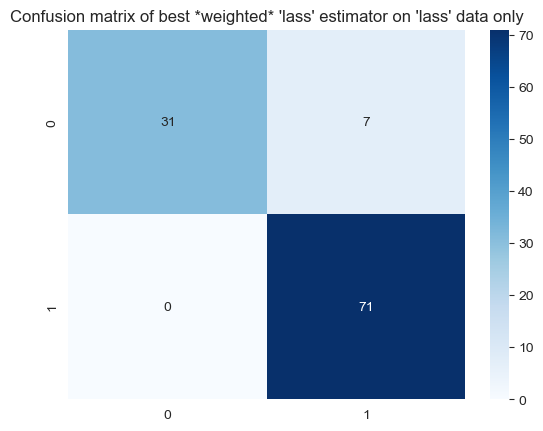

In [158]:
# plot confusion matrix for best weighted lass estimator on lass data only:
X_lass,y_lass = get_user_data(X_prep,source="lass")
y_lass_pred = best_lass_weighted.predict(X_lass)
sns.heatmap(confusion_matrix(y_lass,y_lass_pred),annot=True,fmt="d",cmap="Blues")
plt.title("Confusion matrix of best *weighted* 'lass' estimator on 'lass' data only")
plt.show()

In [159]:
r_dotz = cv_train_user(X_prep,"dotz",target_weight=0.7)
pd.DataFrame(r_dotz.cv_results_).sort_values("mean_test_score",ascending=False).head()

Fitting 4 folds for each of 25 candidates, totalling 100 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
12,0.030387,0.011923,0.001871,0.000053,5,30,"{'clf__max_depth': 5, 'clf__n_estimators': 30}",0.809524,0.746032,0.825397,0.793651,0.793651,0.029696,1
14,0.042889,0.006658,0.002589,0.000382,5,50,"{'clf__max_depth': 5, 'clf__n_estimators': 50}",0.825397,0.730159,0.777778,0.793651,0.781746,0.034366,2
2,0.020367,0.000477,0.001827,0.000031,3,30,"{'clf__max_depth': 3, 'clf__n_estimators': 30}",0.793651,0.714286,0.793651,0.809524,0.777778,0.037226,3
3,0.032661,0.009509,0.002111,0.000096,3,40,"{'clf__max_depth': 3, 'clf__n_estimators': 40}",0.825397,0.682540,0.793651,0.809524,0.777778,0.056120,3
19,0.047639,0.005480,0.002409,0.000027,7,50,"{'clf__max_depth': 7, 'clf__n_estimators': 50}",0.825397,0.714286,0.777778,0.793651,0.777778,0.040468,3


In [160]:
best_dotz_weighted = r_dotz.best_estimator_

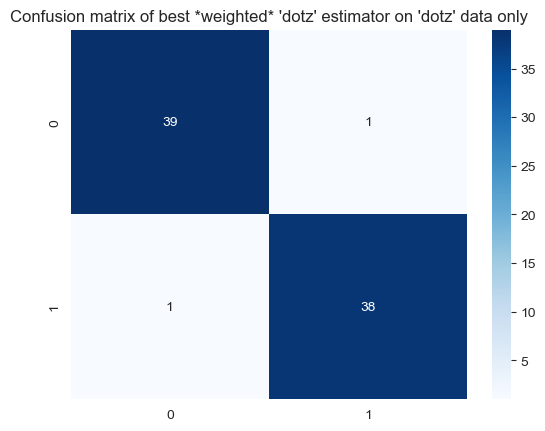

In [161]:
# plot confusion matrix for best weighted dotz estimator on dotz data only:
X_dotz,y_dotz = get_user_data(X_prep,source="dotz")
y_dotz_pred = best_dotz_weighted.predict(X_dotz)
sns.heatmap(confusion_matrix(y_dotz,y_dotz_pred),annot=True,fmt="d",cmap="Blues")
plt.title("Confusion matrix of best *weighted* 'dotz' estimator on 'dotz' data only")
plt.show()